In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Load data
data = pd.read_csv('../data/financial_data_clean.csv', index_col=0, parse_dates=True)
adj_close = data[['TSLA_Adj Close', 'BND_Adj Close', 'SPY_Adj Close']].asfreq('B').fillna(method='ffill')

In [9]:
# Filter for test period: August 1, 2024 - July 31, 2025
test_period = adj_close['2024-08-01':'2025-07-31']
if len(test_period) < 200:
    print(f"Warning: Test period has {len(test_period)} days, expected ~252 trading days.")

# Calculate daily returns
daily_returns = test_period.pct_change().dropna()
print("Daily Returns Summary (Test Period):")
print(daily_returns.describe())

Daily Returns Summary (Test Period):
       TSLA_Adj Close  BND_Adj Close  SPY_Adj Close
count      260.000000     260.000000     260.000000
mean         0.002458       0.000118       0.000723
std          0.044605       0.003166       0.012454
min         -0.154262      -0.012056      -0.058543
25%         -0.022554      -0.001918      -0.002981
50%          0.000000       0.000000       0.000543
75%          0.029321       0.002149       0.005817
max          0.226900       0.011418       0.105019


In [10]:
# Portfolio weights (from Task 4)
max_sharpe_weights = {'TSLA_Adj Close': 0.0, 'BND_Adj Close': 0.0, 'SPY_Adj Close': 1.0}
benchmark_weights = {'TSLA_Adj Close': 0.0, 'BND_Adj Close': 0.4, 'SPY_Adj Close': 0.6}

# Calculate portfolio daily returns
max_sharpe_returns = (daily_returns * pd.Series(max_sharpe_weights)).sum(axis=1)
benchmark_returns = (daily_returns * pd.Series(benchmark_weights)).sum(axis=1)

# Cumulative returns
max_sharpe_cumulative = (1 + max_sharpe_returns).cumprod()
benchmark_cumulative = (1 + benchmark_returns).cumprod()

# Performance metrics
def calculate_metrics(returns, risk_free_rate=0.04, trading_days=252):
    cum_return = (1 + returns).prod() - 1
    ann_return = (1 + cum_return) ** (trading_days / len(returns)) - 1
    ann_volatility = returns.std() * np.sqrt(trading_days)
    sharpe_ratio = (ann_return - risk_free_rate) / ann_volatility
    return cum_return, ann_return, ann_volatility, sharpe_ratio

max_sharpe_metrics = calculate_metrics(max_sharpe_returns)
benchmark_metrics = calculate_metrics(benchmark_returns)

In [11]:
# Save metrics
backtest_metrics = pd.DataFrame({
    'Portfolio': ['Max Sharpe', 'Benchmark'],
    'Cumulative Return': [max_sharpe_metrics[0], benchmark_metrics[0]],
    'Annualized Return': [max_sharpe_metrics[1], benchmark_metrics[1]],
    'Annualized Volatility': [max_sharpe_metrics[2], benchmark_metrics[2]],
    'Sharpe Ratio': [max_sharpe_metrics[3], benchmark_metrics[3]]
})
backtest_metrics.to_csv('../data/backtest_metrics.csv', index=False)
print("\nBacktest Metrics:")
print(backtest_metrics)



Backtest Metrics:
    Portfolio  Cumulative Return  Annualized Return  Annualized Volatility  \
0  Max Sharpe           0.182966           0.176866               0.197693   
1   Benchmark           0.124679           0.120621               0.121571   

   Sharpe Ratio  
0      0.692313  
1      0.663155  


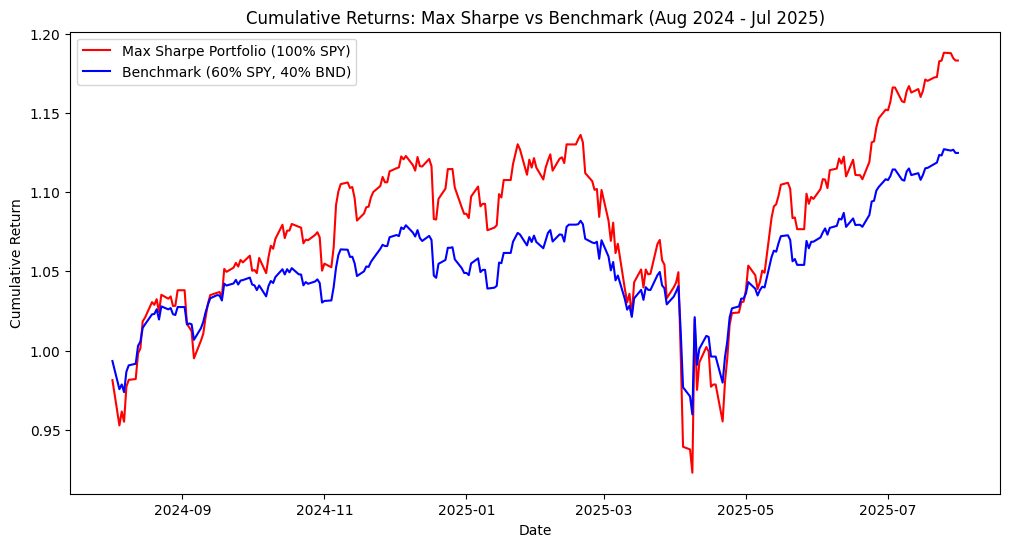

In [12]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(max_sharpe_cumulative, label='Max Sharpe Portfolio (100% SPY)', color='red')
plt.plot(benchmark_cumulative, label='Benchmark (60% SPY, 40% BND)', color='blue')
plt.title('Cumulative Returns: Max Sharpe vs Benchmark (Aug 2024 - Jul 2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
plt.savefig('../plots/backtest_cumulative_returns.png')
plt.close()